Start from AF2 models selected by AF2, nstruct 5

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: jojo


In [3]:
import os, stat

ala_pen = 2
met_pen = 1
np_pen = 3

def create_tasks(selected, subfolder):
    with open(selected, "r") as f:
        for i, line in enumerate(f):
            tasks = {"-s": line.rstrip()}
            tasks["-ala_pen"] = ala_pen
            tasks["-met_pen"] = met_pen
            tasks["-np_pen"] = np_pen
            tasks["-subfolder"] = subfolder
            yield tasks

selected = os.path.join(os.getcwd(), "04_alphafold_one_state/selected.list")

msd_py = os.path.join(os.getcwd(), "msd.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

slurm_dir = os.path.join(os.getcwd(), '05_two_state/slurm_logs')

tasklist = f"05_two_state/run_0/05_msd_tasks_0.cmds"
run_sh = """#!/usr/bin/env bash \n#SBATCH -J 05_two_state \n#SBATCH -e {slurm_dir}/05_two_state-%J.err \n#SBATCH -o {slurm_dir}/05_two_state-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=12G \n
source activate /projects/crispy_shifty/envs/crispy\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
    slurm_dir=slurm_dir, queue='backfill', jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
)
shell = f"05_two_state/run_0/05_msd_0.sh"
with open(shell, "w+") as f:
    print(run_sh, file=f)
st = os.stat(shell)
os.chmod(shell, st.st_mode | stat.S_IEXEC)
with open(tasklist, "w+") as f:
    for nstruct in range(0, 5):
        for tasks in create_tasks(selected, f'{nstruct:04d}'):
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
print(f"sbatch -a 1-$(cat 05_two_state/run_0/05_msd_tasks_0.cmds | wc -l) 05_two_state/run_0/05_msd_0.sh")

Run the following commands
sbatch -a 1-$(cat 05_two_state/run_0/05_msd_tasks_0.cmds | wc -l) 05_two_state/run_0/05_msd_0.sh


In [2]:
# %%time

# retrieve the JSONs containing scores

import json

output_paths = glob("05_two_state/run_0/decoys/*/*.json")

scores = {}
errors = []

for test in tqdm(output_paths):
    key = test.replace("json", "pdb.bz2")
    try:
        with open(test, "r") as f:
            values = json.load(f)
        scores[key] = values
    except json.JSONDecodeError:
        errors.append(test)

0it [00:00, ?it/s]

In [3]:
len(errors)

0

In [4]:
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = "05_two_state/run_0"
output_file = os.path.join(output_path, "scores.json")
scores_df.to_json(output_file)

In [2]:
output_path = "05_two_state/run_0"
output_file = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y
05_two_state/run_0/0004/393805355c4b46c8917affa806ffae8710509640cbdf043b.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,3832.687012,54.325855,54.430744,loop_remodel,loop_match,-1.0,319.447357,555.581421,...,-1191.281616,-1179.631714,0,5,0.227689,0.677451,0.254351,0.461149,0.092366,0.146543
05_two_state/run_0/0004/ec273601d795e6517d6418c0e2fbbe2338c6687d9fad0a5f.pdb.bz2,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,150.075790,74.775955,74.775955,loop_match,loop_match,-1.0,571.576660,758.473816,...,-1169.193115,-1082.741333,0,4,0.401098,0.877094,0.308621,0.550762,0.137486,0.212980
05_two_state/run_0/0004/49c5fa528e071bf185292868b8ed020ed7edbd0d3373fe65.pdb.bz2,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,126.997520,61.185627,61.185627,loop_match,loop_match,-1.0,506.618805,752.389832,...,-1004.082031,-1006.921265,0,2,0.230769,0.487113,0.240367,0.405601,0.095980,0.152266
05_two_state/run_0/0004/385128086c60116a2667a11ca3ad8ec86e8ea8369b9f42d3.pdb.bz2,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,124.986877,61.185627,61.185627,loop_match,loop_match,-1.0,543.848694,767.983582,...,-1065.406250,-965.299866,0,4,0.183278,0.536907,0.572410,0.638924,0.131289,0.145066
05_two_state/run_0/0004/35b7931c932e50dfbbdbfcf108ea254a56a3233dce315326.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAABAABAAAAAAAAAAAAAAAAAAA...,1328.937988,59.111366,58.997833,loop_remodel,loop_match,-1.0,653.203064,812.871704,...,-1345.717896,-1253.284424,0,1,0.317264,0.878735,0.390187,0.623361,0.119002,0.263615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_0/0001/9bed3168236c6d5f67f5db9f6735f9c5ee95f30f87c4141c.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,134.632263,63.489902,63.489902,loop_remodel,loop_match,-1.0,488.375092,802.945801,...,-1382.800903,-1228.427856,0,9,0.350054,1.103493,0.288418,0.558455,0.120501,0.147048
05_two_state/run_0/0001/c977660a1d36a1a346c3d8cbff92fad43b07024bafc999ae.pdb.bz2,XBAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAA...,XBAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAA...,130.368454,55.878143,55.878143,loop_match,loop_remodel,-1.0,456.120941,649.947327,...,-1142.826660,-1130.450562,0,2,0.291861,0.729220,0.214950,1.130577,0.114452,0.126340
05_two_state/run_0/0001/f0d113ab92f020853e521efc2c0034ad9f5d81586735475c.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAA...,219.901596,76.942032,76.900528,loop_remodel,loop_remodel,-1.0,457.690979,587.693298,...,-1292.619019,-1240.162598,0,1,0.274028,0.517726,0.289972,0.673851,0.126733,0.177776
05_two_state/run_0/0001/fb33b8da909b1fdf04f7879bc0884edf08c1c3955fb0ffac.pdb.bz2,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,XAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAAB...,485.579468,52.802925,57.474747,loop_match,loop_match,-1.0,433.888641,737.512512,...,-980.224487,-1012.589478,1,3,0.282484,0.600107,0.270758,0.782632,0.098745,0.170429


In [3]:
print(', '.join(scores_df.columns))

abego_str_A, abego_str_B, bb_clash, bb_clash_A, bb_clash_B, closure_type_A, closure_type_B, cms_ac_bn, cms_dhr, cms_dhr_ac, cms_dhr_bn, dhr_ac_int_count, dhr_bn_int_count, dhr_int_count, dssp_A, dssp_B, fa_dun, fa_intra_rep, lk_ball_wtd, loop_dist_A, loop_dist_B, loop_sc_A, loop_sc_B, model, new_loop_resis, new_loop_resis_A, new_loop_resis_B, parent, parent_length, parent_loop_dist, parent_path, pivot_helix_A, pivot_helix_B, pre_break_helix, remodel_after_loop_A, remodel_before_loop_A, sc_ac_bn, sc_dhr, sc_dhr_ac, sc_dhr_bn, score, score_1, score_124, score_134, score_14, score_2, score_23, score_3, score_4, score_per_res, shift_A, shift_B, ss_sc, type, wnm_1, wnm_2, wnm_3, wnm_4, wnm_A, wnm_B, wnm_hlx, yhh_planarity, ala_penalty, buns_X, buns_Y, cms_Y, ddg_Y, dslf_fa13, dslf_fa13_X, dslf_fa13_Y, exposed_hydrophobics_X, exposed_hydrophobics_Y, fa_atr, fa_atr_X, fa_atr_Y, fa_dun_dev, fa_dun_dev_X, fa_dun_dev_Y, fa_dun_rot, fa_dun_rot_X, fa_dun_rot_Y, fa_dun_semi, fa_dun_semi_X, fa_dun_s

In [3]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

In [4]:
def histplot_df(df):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for ax, col in zip(axs.flatten(),cols):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
    #         kde=True
    #         hue='parent'
        )

    plt.tight_layout()

In [5]:
def kdeplot_df(df, hue_col, hue_order=None):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "sap_X",
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for i, (ax, col) in enumerate(zip(axs.flatten(),cols)):
        sns.kdeplot(
            data=df,
            x=col,
            ax=ax,
            hue=hue_col,
            hue_order=hue_order,
            legend=False
            # legend=(not i) # only creates the legend for the first plot
        )

    plt.tight_layout()

In [6]:
def copy_designs(df, out_dir):
    import os
    import shutil
    # Copy designs to a folder
    os.makedirs(out_dir, exist_ok=True)
    
    keys = ['parent',
            'Y-X',
            'sap_A_X',
            'sap_B_X',
            'sap_Y',
            'sc_int_Y',
            'wnm_hlx_X',
            'wnm_hlx_Y',
            'wnm_all_A_X',
            'wnm_all_B_X',
            'wnm_all_A_Y',
            'wnm_all_B_Y',
           ]

    for index, row in df.iterrows():
        filename = out_dir
        for key in keys:
            val = row[key]
            if type(val) != str:
                val = f'_{val:.03f}'
            filename += val
        filename += '.pdb'
    #     print(filename)
        shutil.copy(index[:-4], filename)

In [24]:
def print_scores(df):
    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        "parent",
    ]
    print_df = df[cols]

    from IPython.display import display
    with pd.option_context(
        # 'display.max_rows', 5,
        'display.max_columns', None,
        # 'display.width', 1000,
        # 'display.precision', 3,
        # 'display.colheader_justify', 'left'
    ):
        display(print_df)

In [8]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [9]:
def get_parents(df):
    parents = []
    for key, row in df.iterrows():
        parent = row['parent']
        if parent not in parents:
            parents.append(parent)
    print(len(parents))
    return parents

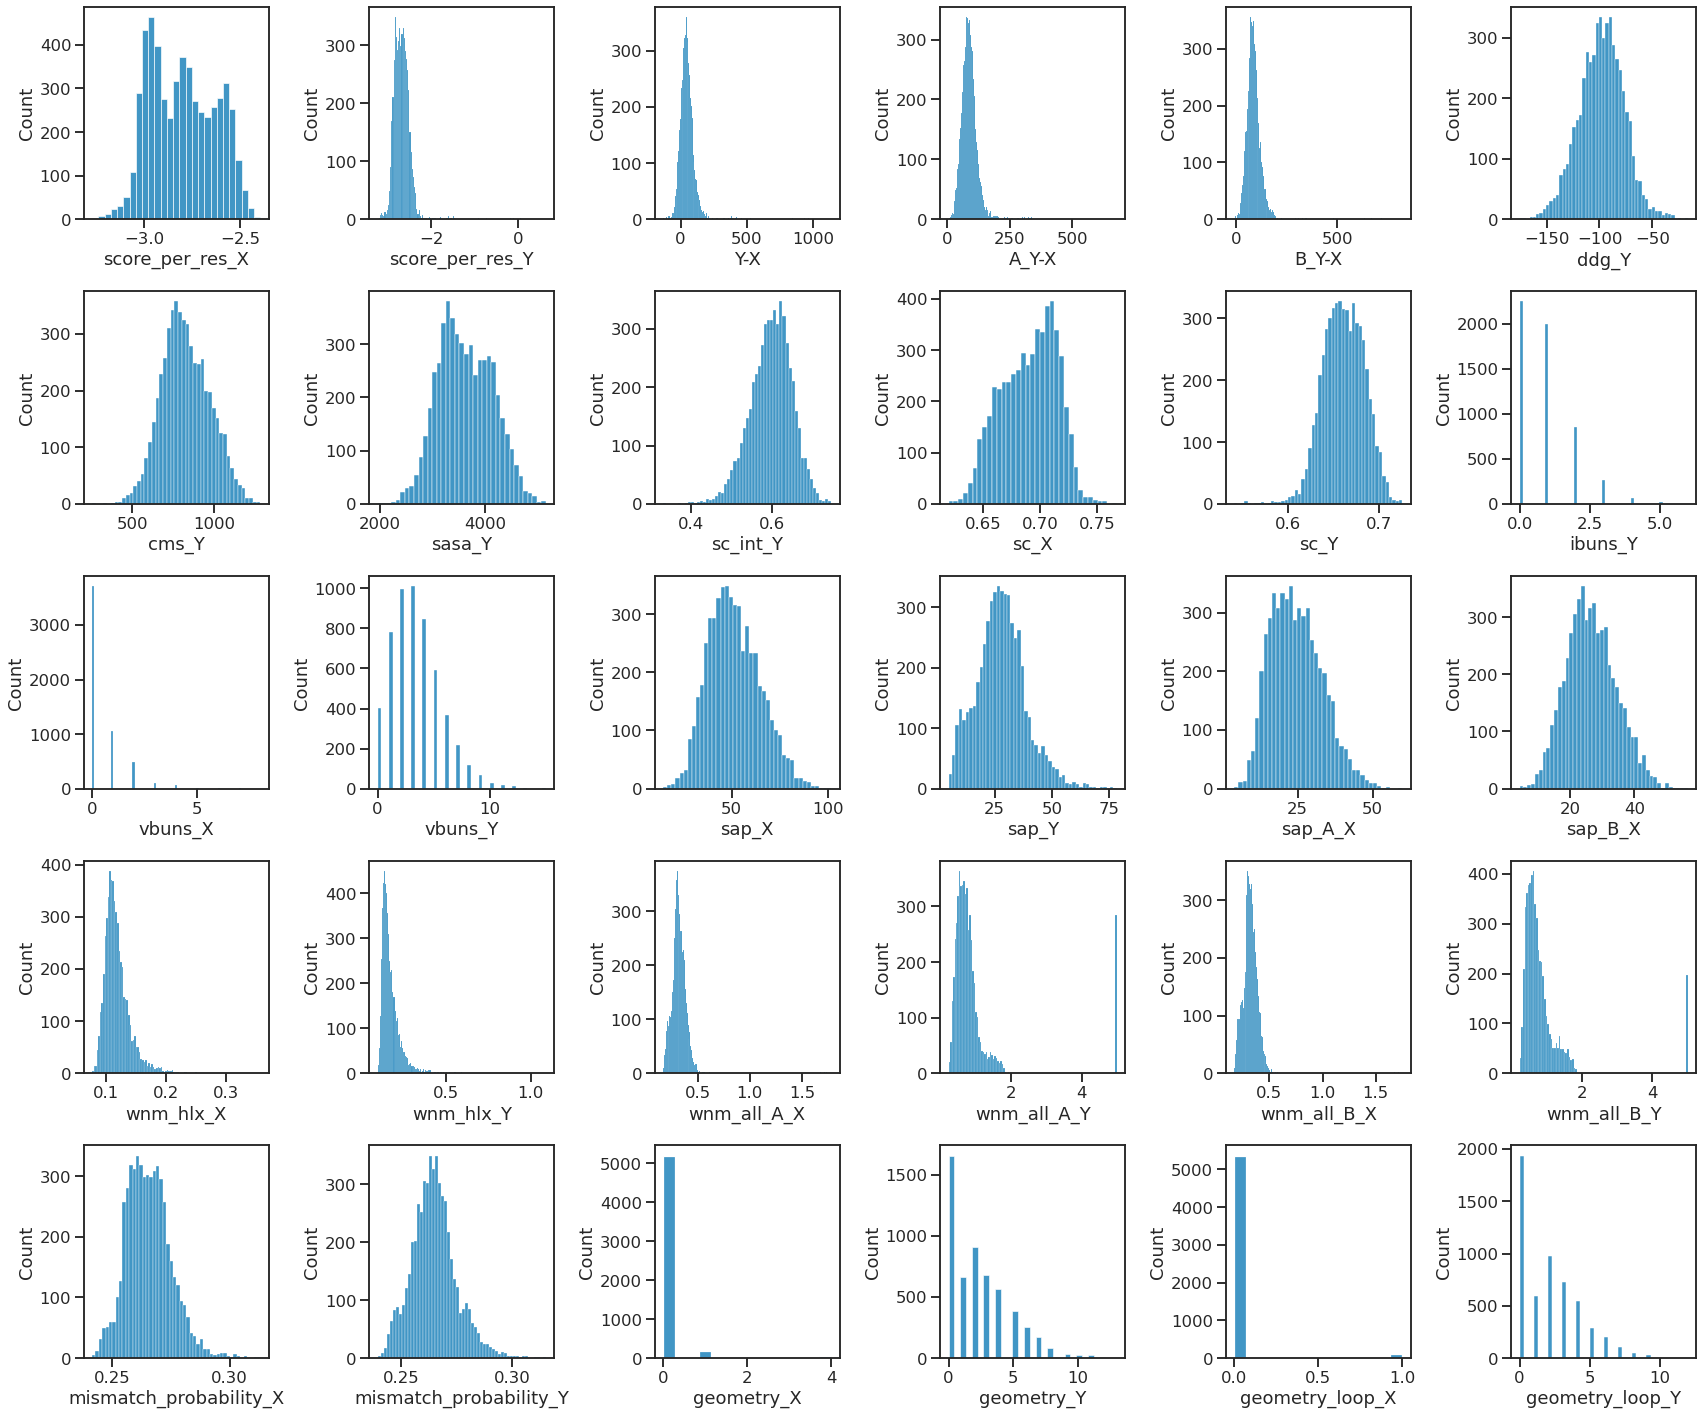

In [10]:
histplot_df(scores_df)

In [11]:
all_parents = get_parents(scores_df)
print(all_parents)

59
['X26_3_20_2_ct1_fe', 'hDHR79_5CWP', 'X19_3_18_4_ct4_fd', 'X23_4_26_3_ct8_fc', 'X18_4_23_4_ct3_ff', 'X24_4_24_3_ct3_fc', 'hDHR64_5CWM', 'X23_2_15_3_ct5_fe', 'X26_3_26_4_ct2_fe', 'X26_3_27_4_ct2_fe', 'KH_PO11', 'X20_3_18_2_ct3_fa', 'X18_4_22_4_ct0_ff', 'DHR79', 'DHR71', 'X22_4_20_3_ct0_ff', 'X27_3_19_4_ct3_fe', 'X22_3_16_4_ct4_fa', 'hDHR71_5CWN', 'X19_3_17_2_ct9_fe', 'X26_3_23_4_ct1_fd', 'X17_3_21_2_ct0_fd', 'DHR39', 'X19_4_19_4_ct5_fa', 'DHR82', 'X21_4_23_4_ct0_fg', 'X19_3_19_3_ct11_fc', 'X16_3_18_4_ct6_fe', 'TH_DHR_T7', 'X16_4_15_3_ct0_fc', 'X26_3_24_2_ct12_fe', 'DHR26_nocys', 'X28_2_25_2_ct2_fb', 'X22_4_23_3_ct6_fa', 'X24_2_24_2_ct18_fg', 'X19_3_17_2_ct6_fc', 'X16_4_16_2_ct7_fe', 'X24_2_24_2_ct5_ff', 'X17_4_20_3_ct10_fb', 'X27_2_27_2_ct5_fg', 'X20_3_25_2_ct9_fa', 'X23_4_25_4_ct0_fa', 'DHR62', 'X16_3_19_3_ct33_fc', 'X17_4_21_2_ct3_fd', 'X23_3_20_3_ct7_fc', 'hDHR53_5CWK', 'X20_3_18_2_ct13_fe', 'X20_3_18_2_ct6_fa', 'X19_4_18_2_ct6_fg', 'X17_4_20_3_ct4_fa', 'X19_3_17_2_ct28_fe', 'TH_D

5383


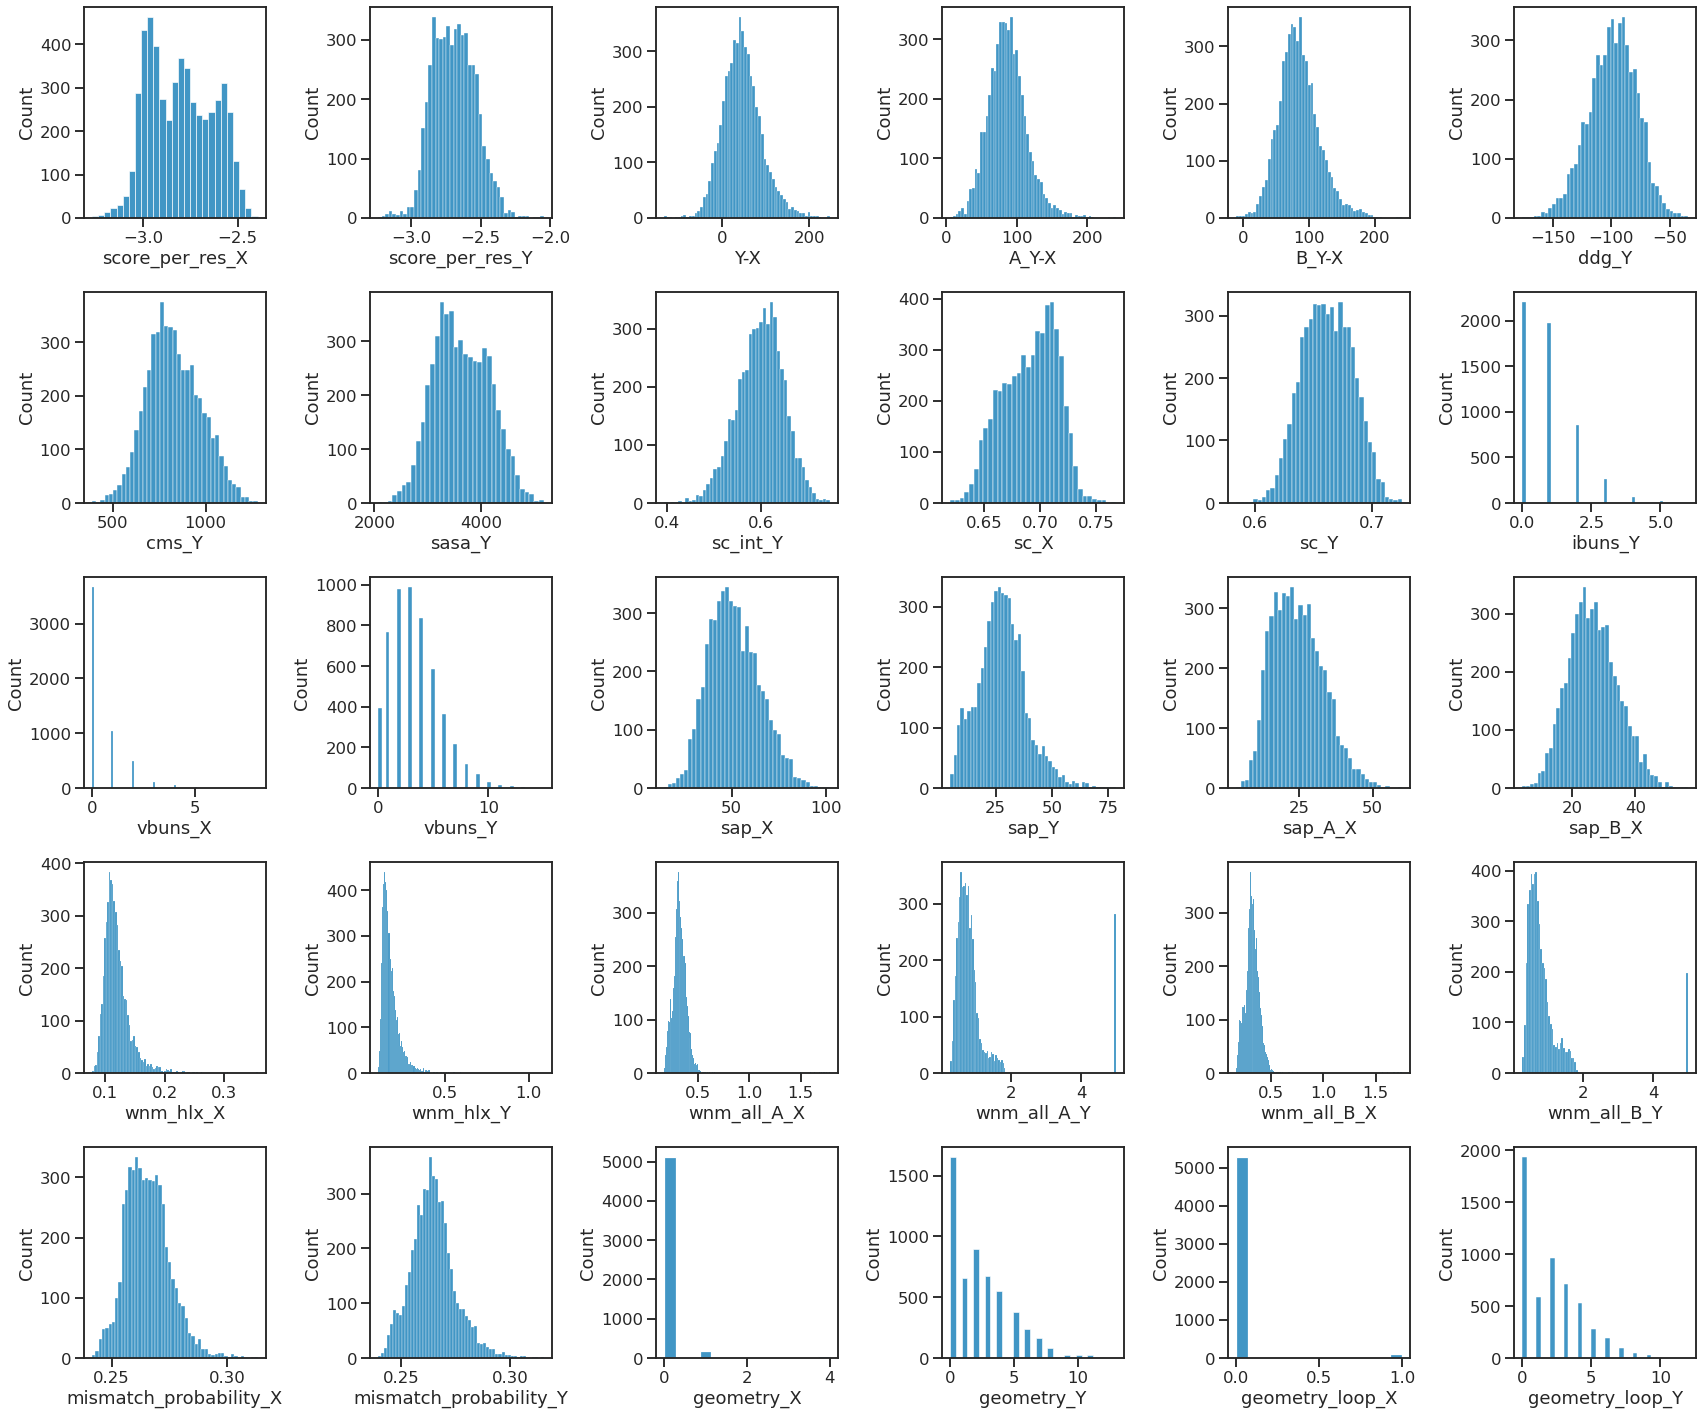

In [12]:
# Remove outliers

cutoffs = [('Y-X', 250, 0),
           ('sc_Y', 0.58, 1),
           ('score_per_res_Y', -2, 0)
]

no_outliers_df = filter_df(scores_df, cutoffs)
histplot_df(no_outliers_df)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/projects/crispy_shifty/

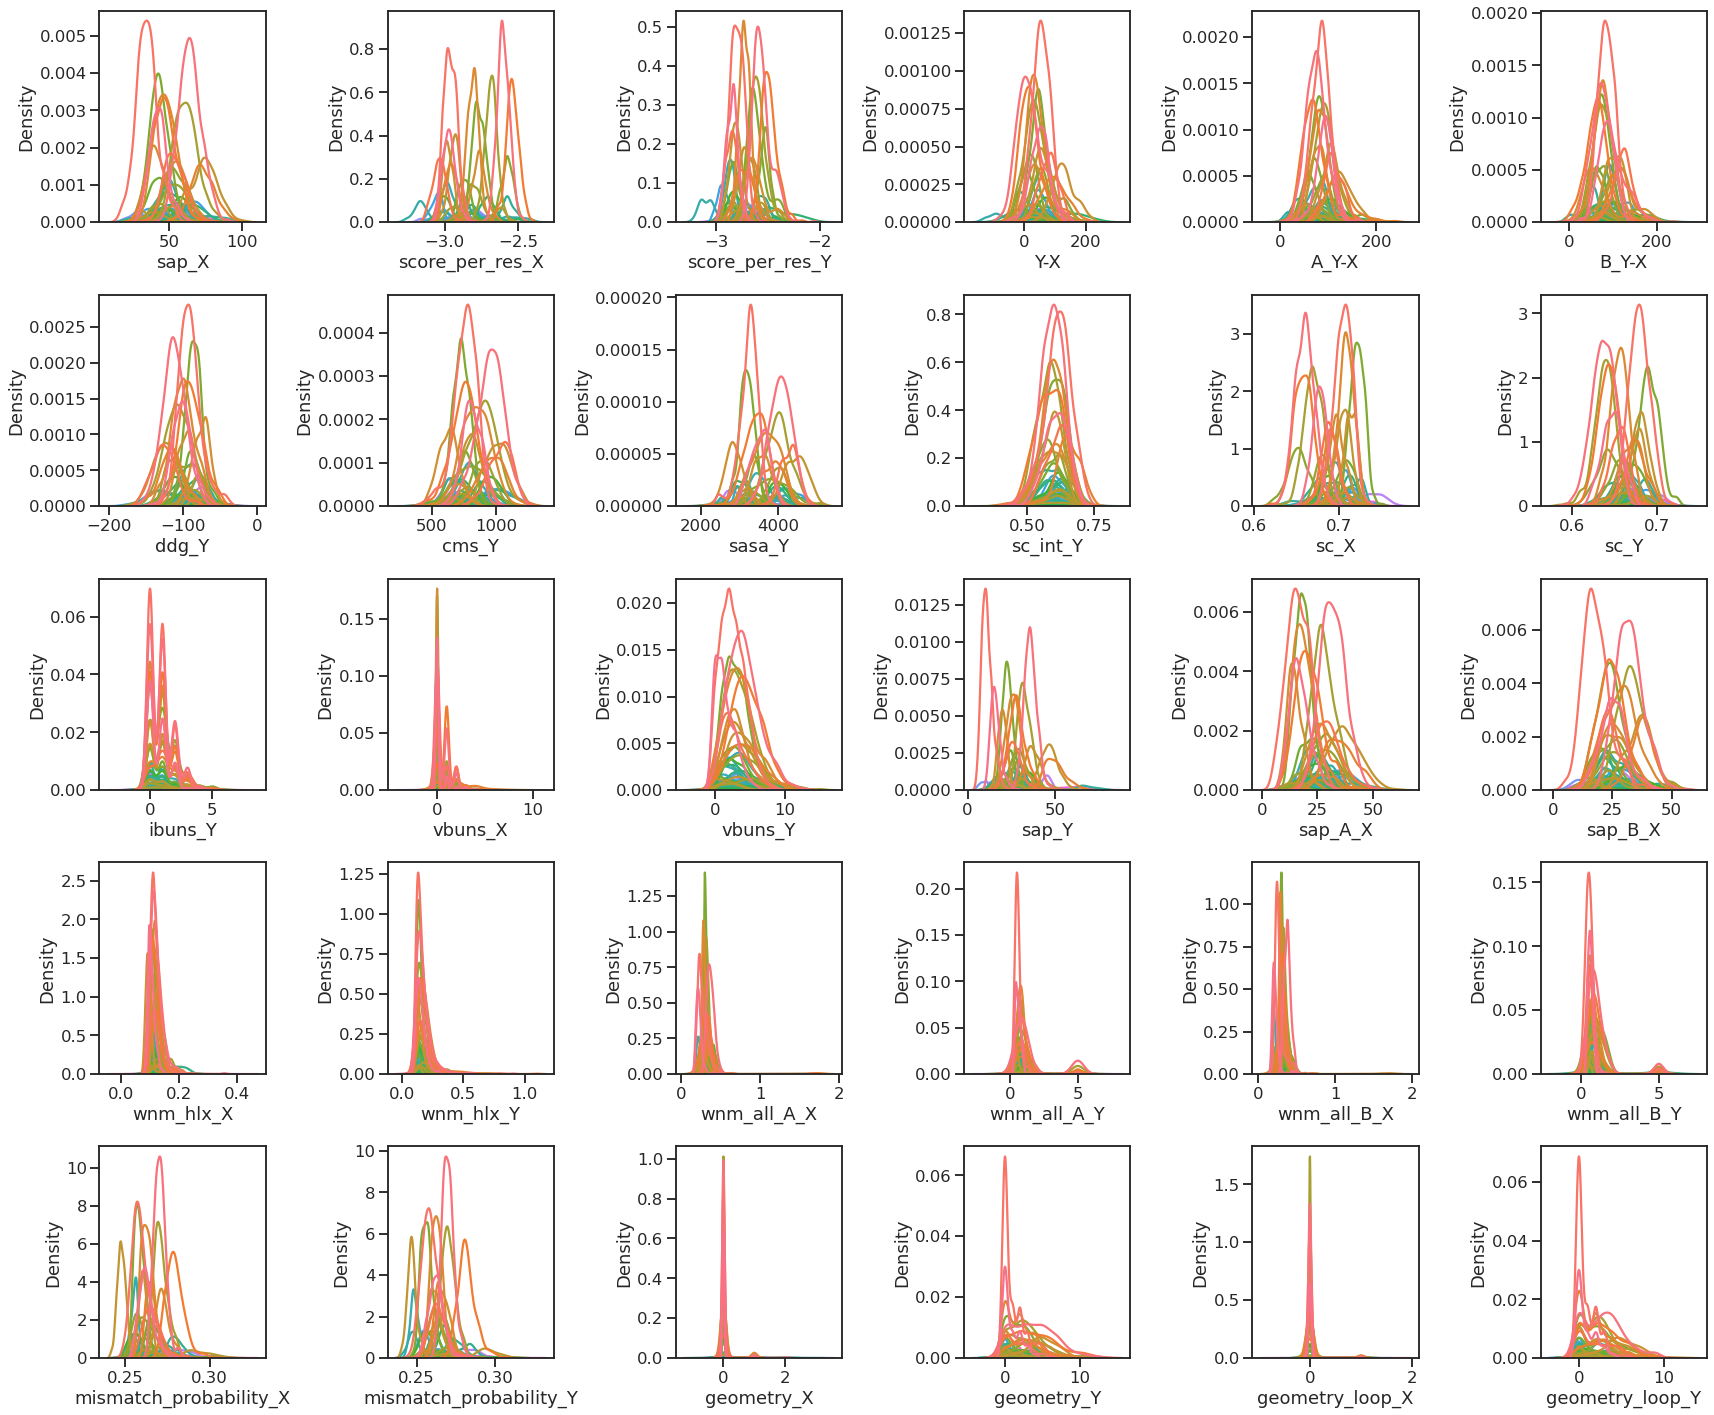

In [13]:
kdeplot_df(no_outliers_df, 'parent')

In [25]:
# Filter designs- stringent global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.30, 0),
           ('wnm_hlx_Y', 0.30, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

18


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_0/0004/709145e5bfc8ed96199b7435a1d1549224f3908fc0e3efdd.pdb.bz2,-2.859330,-2.924811,-26.716187,77.254120,41.554504,-123.710442,892.214111,3639.450195,0.676246,0.673042,0.641592,1,0,2,43.318966,12.404548,16.317356,27.001644,0.117465,0.123161,0.240232,0.470707,0.200628,0.567549,0.271185,0.269638,0,0,0,0,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/f3ba8dc552d2c22f708c1d9e2acde0ab6ed67b987550bbb0.pdb.bz2,-2.564200,-2.638698,-29.203186,51.294556,63.957550,-114.251060,839.028809,3455.084229,0.675524,0.640845,0.661475,1,1,2,44.313747,22.369389,16.217798,28.095968,0.098851,0.215237,0.344015,0.761072,0.287292,0.678385,0.271638,0.275332,0,5,0,3,X18_4_23_4_ct3_ff
05_two_state/run_0/0004/342e3a90b2e6ef85e3313c81fd3b144d0c291083df12b37e.pdb.bz2,-2.860420,-2.955110,-38.633667,51.208618,65.689270,-122.248672,905.173279,3737.756592,0.658230,0.672870,0.653689,0,0,0,43.202984,14.716944,15.435175,27.767809,0.123907,0.158692,0.200397,0.473582,0.222487,0.348377,0.258614,0.255383,0,2,0,2,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/8a4c0893cd2adeba83d7e5cc4469f640358913c224f097ed.pdb.bz2,-2.573097,-2.612481,-12.918152,63.561981,38.316833,-91.626884,760.581299,3209.932129,0.659692,0.675880,0.659460,0,0,2,55.122513,22.695265,28.711634,26.410919,0.103667,0.166212,0.328011,0.851530,0.343687,0.669652,0.279766,0.275956,0,1,0,0,X16_3_18_4_ct6_fe
05_two_state/run_0/0003/c8e616bea650b6a64cc0747ebe6aef450e38e457e9f1c10c.pdb.bz2,-2.905392,-2.992177,-35.408325,38.433716,64.093445,-115.960030,835.481995,3327.903320,0.669772,0.664023,0.664442,0,0,2,45.647755,18.951069,22.320330,23.327414,0.109407,0.210978,0.265724,0.439304,0.199074,0.441164,0.266879,0.268308,0,0,0,0,X26_3_20_2_ct1_fe
05_two_state/run_0/0003/da89e7476b0c3665b7d7bd575055f45bd8bf7375d751b969.pdb.bz2,-2.625891,-2.674498,-16.720825,41.108551,46.136108,-85.350853,641.912842,2792.519287,0.686753,0.685635,0.680797,1,0,1,48.155155,17.371958,22.691635,25.463512,0.107170,0.273255,0.258932,0.413962,0.334276,0.695609,0.266470,0.264181,0,0,0,0,X23_2_15_3_ct5_fe
05_two_state/run_0/0000/a4e0a5ff1c9d8f3f5de8f3f2d1e4f55b0da8eb5421e7d5fd.pdb.bz2,-2.557771,-2.642504,-27.791992,49.504944,22.578369,-79.568954,652.889832,2858.237793,0.673426,0.670860,0.649879,0,0,0,54.203941,29.755569,28.920343,25.283606,0.125945,0.130008,0.321496,0.612430,0.375802,0.570994,0.281441,0.272483,0,3,0,3,X16_3_18_4_ct6_fe
05_two_state/run_0/0000/42d2d661003fa87841d2cb2cf3debcdbcceabcf785f5682c.pdb.bz2,-2.954347,-3.068979,-37.599365,86.920532,9.463196,-112.072807,850.406738,3364.415527,0.673044,0.742292,0.712495,0,0,2,41.633877,15.115495,17.945951,23.687954,0.131635,0.167161,0.280312,0.622976,0.314059,0.361675,0.270079,0.262788,0,0,0,0,X19_3_17_2_ct28_fe
05_two_state/run_0/0000/42a03214afabbf12bee98706ea5a5382f42df674afba5aef.pdb.bz2,-2.736396,-2.793346,-19.590759,32.830811,49.089386,-87.607002,675.748657,2859.187988,0.652387,0.702890,0.687813,0,0,2,24.083025,7.726285,17.953526,6.129496,0.103358,0.181351,0.202023,0.430515,0.213827,0.898006,0.281368,0.276061,0,2,0,2,DHR62
05_two_state/run_0/0002/ade0fa46e8eccdd4ad3c3aad6c8c8b5c2284204ce5f07932.pdb.bz2,-2.761818,-2.845729,-38.263184,47.972900,64.601196,-134.860550,886.812195,3972.697266,0.659912,0.713678,0.674093,0,0,2,46.543961,27.618843,24.495338,22.048609,0.127639,0.124009,0.321870,0.750227,0.361734,0.651889,0.257367,0.257091,0,0,0,0,hDHR64_5CWM


In [13]:
all_parents = get_parents(global_df)
print(all_parents)

10
['X26_3_20_2_ct1_fe', 'X18_4_23_4_ct3_ff', 'X16_3_18_4_ct6_fe', 'X23_2_15_3_ct5_fe', 'X19_3_17_2_ct28_fe', 'DHR62', 'hDHR64_5CWM', 'X19_3_17_2_ct9_fe', 'X16_4_16_2_ct7_fe', 'X19_3_18_4_ct4_fd']


In [21]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_0/global_filter/'
copy_designs(global_df, out_dir)

177


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_0/0004/9d2488f53920b36aa8a7202c2a965639e43693f7ae6573bb.pdb.bz2,-2.918660,-2.812741,37.283569,99.477051,60.762207,-103.690155,877.119812,3513.656982,0.650566,0.691361,0.694021,0,0,2,29.613993,8.307743,9.706813,19.907190,0.118317,0.150755,0.252148,0.430624,0.279467,0.633600,0.257180,0.249566,0,0,0,0,X19_3_18_4_ct4_fd
05_two_state/run_0/0004/b0b4ff977a28312ce8e0ccf60c7f8a3602ed4942c3f6cdda.pdb.bz2,-3.023713,-2.877045,59.840576,75.101379,94.104614,-94.929543,678.807800,3096.522217,0.664763,0.681357,0.659548,0,0,0,39.935490,19.215000,14.198319,25.737181,0.090867,0.129992,0.184644,0.346471,0.202797,0.328929,0.259486,0.260337,0,1,0,1,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/709145e5bfc8ed96199b7435a1d1549224f3908fc0e3efdd.pdb.bz2,-2.859330,-2.924811,-26.716187,77.254120,41.554504,-123.710442,892.214111,3639.450195,0.676246,0.673042,0.641592,1,0,2,43.318966,12.404548,16.317356,27.001644,0.117465,0.123161,0.240232,0.470707,0.200628,0.567549,0.271185,0.269638,0,0,0,0,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/03425fc658b2a3c62d16b616587625b1e345e303beb8dcf8.pdb.bz2,-2.770446,-2.693693,26.403015,71.632935,67.927307,-88.366478,762.377075,3267.050537,0.665380,0.700551,0.677018,0,0,1,39.457615,20.698395,15.988212,23.469381,0.132174,0.139991,0.286591,0.523405,0.309289,0.778598,0.266219,0.261733,0,0,0,0,X23_2_15_3_ct5_fe
05_two_state/run_0/0004/442d812246ced5db3e766e31ffdf7bccd7ca3baa8e9c7818.pdb.bz2,-2.731744,-2.387370,123.974670,92.745483,146.566895,-86.910835,788.328003,3149.111084,0.695830,0.710894,0.697970,1,0,2,38.375412,25.035143,17.836733,20.538677,0.133582,0.140444,0.301169,0.677623,0.299742,0.560500,0.259569,0.256640,0,5,0,4,X22_3_16_4_ct4_fa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_0/0001/cd270ad46d8512073a395e3b867700b38967d2fe853afe3a.pdb.bz2,-2.774923,-2.698266,34.955933,86.263916,74.912048,-99.034843,892.009277,3842.902832,0.667291,0.707480,0.658232,0,0,2,51.410210,32.083172,21.698769,29.711422,0.123376,0.239900,0.271929,0.500789,0.335615,0.558772,0.257822,0.256469,0,2,0,2,hDHR64_5CWM
05_two_state/run_0/0001/592bd9f039761c7ffb972a10de11178fd54f1d18ac6c501c.pdb.bz2,-2.822492,-2.844486,-10.029541,52.047729,93.060181,-132.508453,1046.819336,4213.354980,0.664130,0.709272,0.671192,1,0,0,46.790245,17.991116,17.855225,28.935032,0.114964,0.211816,0.267785,0.674550,0.330713,0.496603,0.261040,0.261433,0,0,0,0,hDHR64_5CWM
05_two_state/run_0/0001/f3d2364c88b40a6d25ddbccdf5b898a72a716eab8fa8fef9.pdb.bz2,-2.743406,-2.255841,179.423706,93.938080,182.873688,-79.006630,680.144104,2884.532715,0.666330,0.703151,0.655676,2,0,2,52.591316,30.321421,25.705538,26.885773,0.104458,0.161161,0.373872,0.703396,0.319438,0.809005,0.266568,0.264212,0,3,0,3,X19_4_19_4_ct5_fa
05_two_state/run_0/0001/9f3acc9514a12b251309c0eaca32288781ef16343c51f1c7.pdb.bz2,-2.965904,-2.845571,42.356995,79.237549,88.856262,-107.101364,819.618164,3397.641602,0.661215,0.706738,0.692861,1,0,0,28.264990,7.993622,10.874179,17.390814,0.108578,0.149593,0.429563,0.653995,0.233103,0.750986,0.258518,0.257677,0,0,0,0,X19_3_18_4_ct4_fd


31
['X19_3_18_4_ct4_fd', 'X26_3_20_2_ct1_fe', 'X23_2_15_3_ct5_fe', 'X22_3_16_4_ct4_fa', 'X18_4_23_4_ct3_ff', 'hDHR64_5CWM', 'hDHR71_5CWN', 'X16_3_18_4_ct6_fe', 'X26_3_23_4_ct1_fd', 'X26_3_24_2_ct12_fe', 'X24_2_24_2_ct18_fg', 'X16_4_16_2_ct7_fe', 'X19_4_19_4_ct5_fa', 'X23_4_26_3_ct8_fc', 'DHR79', 'X20_3_18_2_ct13_fe', 'X19_3_17_2_ct9_fe', 'X26_3_26_4_ct2_fe', 'X20_3_25_2_ct9_fa', 'X22_4_20_3_ct0_ff', 'hDHR53_5CWK', 'X19_3_17_2_ct28_fe', 'DHR62', 'X27_3_19_4_ct3_fe', 'KH_PO11', 'X19_3_17_2_ct6_fc', 'X21_2_18_2_ct0_fg', 'X27_2_27_2_ct5_fg', 'X20_3_18_2_ct3_fa', 'X18_4_22_4_ct0_ff', 'X28_2_25_2_ct2_fb']


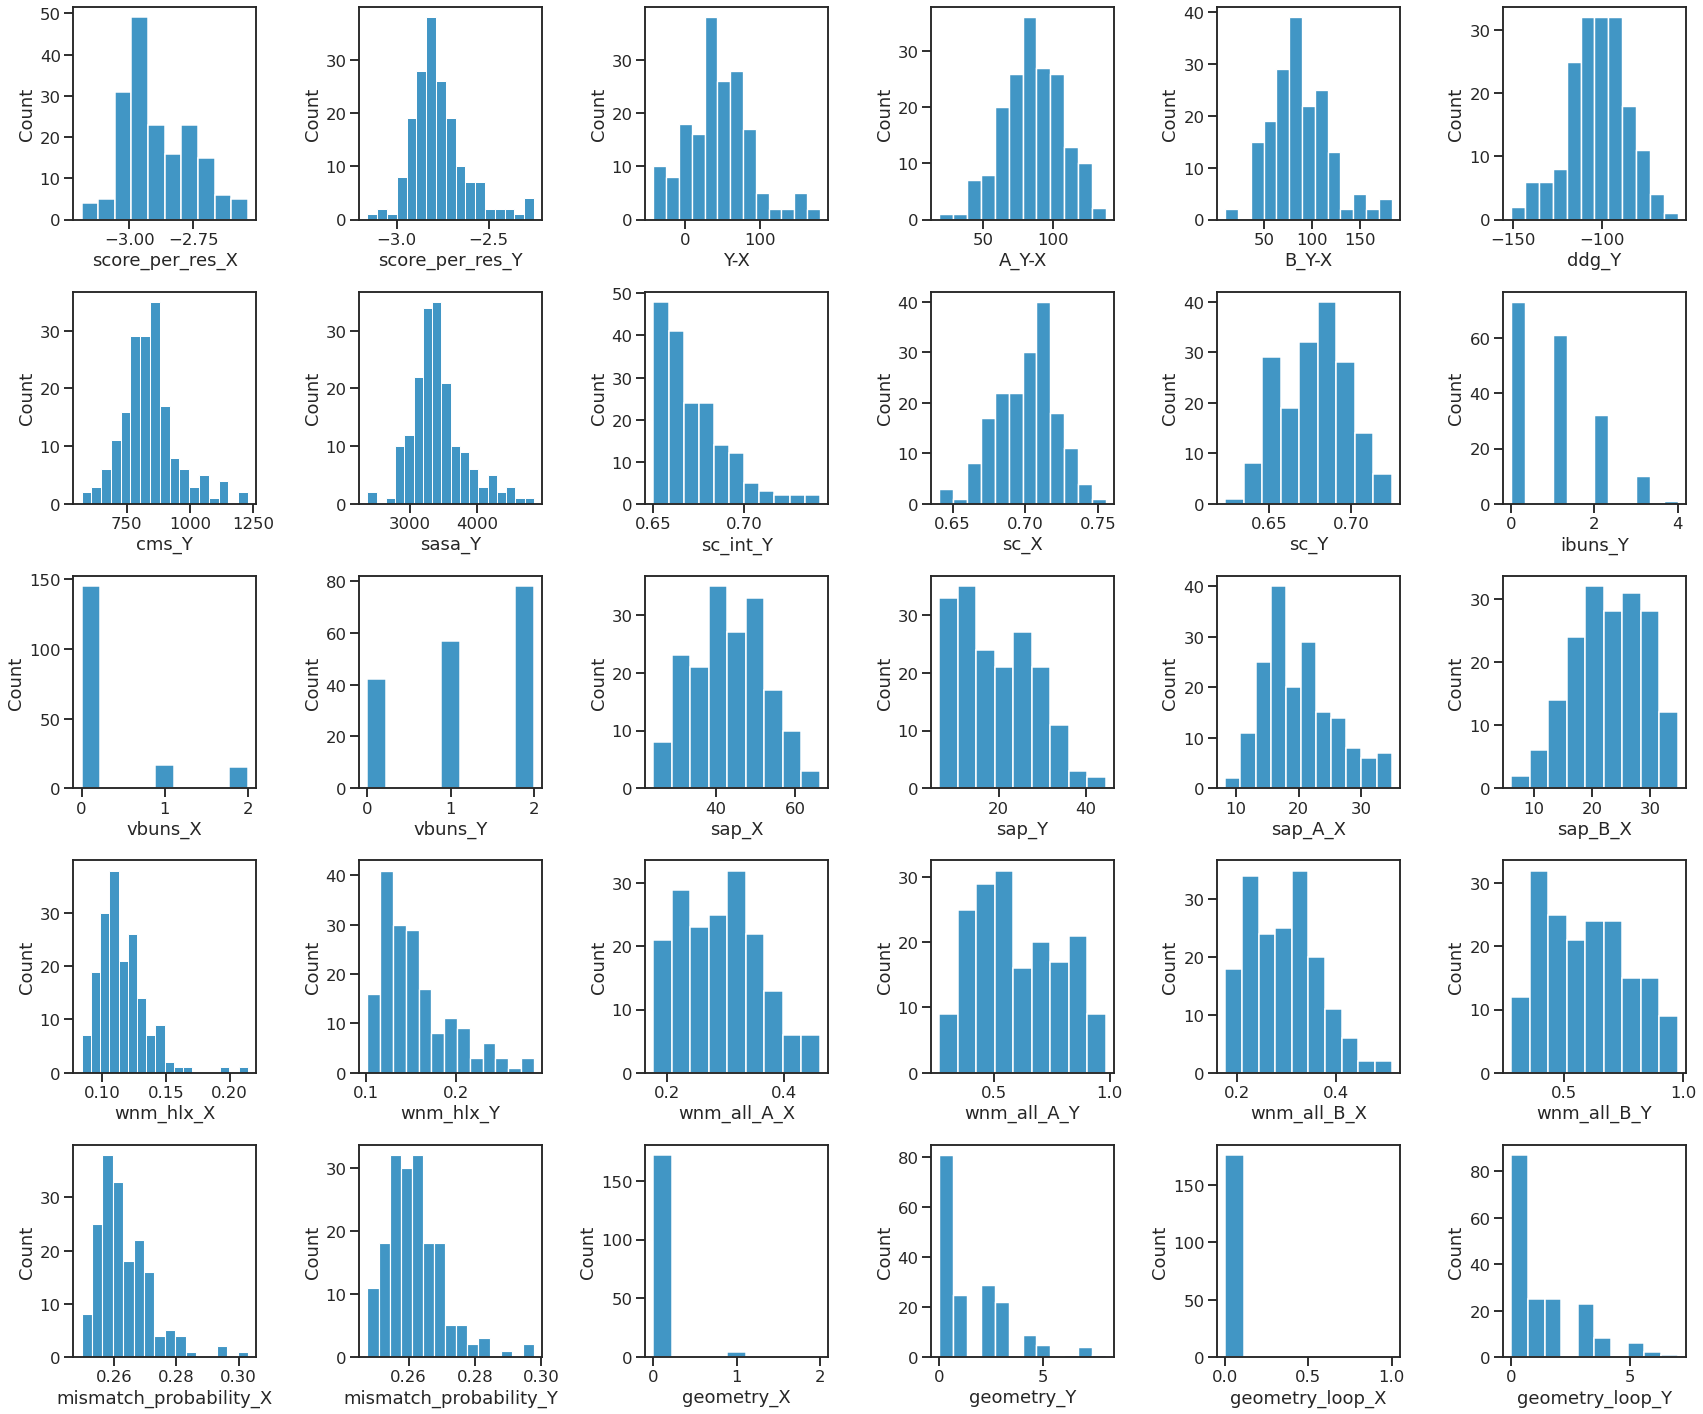

In [27]:
# Filter designs- lenient global filter

cutoffs = [
        #    ('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.30, 0),
           ('wnm_hlx_Y', 0.30, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

lenient_global_df = filter_df(scores_df, cutoffs)
print_scores(lenient_global_df)
print(get_parents(lenient_global_df))
histplot_df(lenient_global_df)

339


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_0/0004/9d2488f53920b36aa8a7202c2a965639e43693f7ae6573bb.pdb.bz2,-2.918660,-2.812741,37.283569,99.477051,60.762207,-103.690155,877.119812,3513.656982,0.650566,0.691361,0.694021,0,0,2,29.613993,8.307743,9.706813,19.907190,0.118317,0.150755,0.252148,0.430624,0.279467,0.633600,0.257180,0.249566,0,0,0,0,X19_3_18_4_ct4_fd
05_two_state/run_0/0004/b0b4ff977a28312ce8e0ccf60c7f8a3602ed4942c3f6cdda.pdb.bz2,-3.023713,-2.877045,59.840576,75.101379,94.104614,-94.929543,678.807800,3096.522217,0.664763,0.681357,0.659548,0,0,0,39.935490,19.215000,14.198319,25.737181,0.090867,0.129992,0.184644,0.346471,0.202797,0.328929,0.259486,0.260337,0,1,0,1,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/709145e5bfc8ed96199b7435a1d1549224f3908fc0e3efdd.pdb.bz2,-2.859330,-2.924811,-26.716187,77.254120,41.554504,-123.710442,892.214111,3639.450195,0.676246,0.673042,0.641592,1,0,2,43.318966,12.404548,16.317356,27.001644,0.117465,0.123161,0.240232,0.470707,0.200628,0.567549,0.271185,0.269638,0,0,0,0,X26_3_20_2_ct1_fe
05_two_state/run_0/0004/c2dedac1bfb0c4a99449c3b518c97d4714e93068da9650b7.pdb.bz2,-3.022674,-2.827411,87.477661,131.349548,129.731628,-136.177673,1175.525513,4649.513672,0.645948,0.667437,0.636255,1,1,2,45.212585,24.943354,21.972279,23.240313,0.104687,0.199975,0.339931,0.920082,0.315991,0.801129,0.258980,0.256930,0,4,0,4,X23_4_26_3_ct8_fc
05_two_state/run_0/0004/03425fc658b2a3c62d16b616587625b1e345e303beb8dcf8.pdb.bz2,-2.770446,-2.693693,26.403015,71.632935,67.927307,-88.366478,762.377075,3267.050537,0.665380,0.700551,0.677018,0,0,1,39.457615,20.698395,15.988212,23.469381,0.132174,0.139991,0.286591,0.523405,0.309289,0.778598,0.266219,0.261733,0,0,0,0,X23_2_15_3_ct5_fe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_0/0001/592bd9f039761c7ffb972a10de11178fd54f1d18ac6c501c.pdb.bz2,-2.822492,-2.844486,-10.029541,52.047729,93.060181,-132.508453,1046.819336,4213.354980,0.664130,0.709272,0.671192,1,0,0,46.790245,17.991116,17.855225,28.935032,0.114964,0.211816,0.267785,0.674550,0.330713,0.496603,0.261040,0.261433,0,0,0,0,hDHR64_5CWM
05_two_state/run_0/0001/f3d2364c88b40a6d25ddbccdf5b898a72a716eab8fa8fef9.pdb.bz2,-2.743406,-2.255841,179.423706,93.938080,182.873688,-79.006630,680.144104,2884.532715,0.666330,0.703151,0.655676,2,0,2,52.591316,30.321421,25.705538,26.885773,0.104458,0.161161,0.373872,0.703396,0.319438,0.809005,0.266568,0.264212,0,3,0,3,X19_4_19_4_ct5_fa
05_two_state/run_0/0001/9f3acc9514a12b251309c0eaca32288781ef16343c51f1c7.pdb.bz2,-2.965904,-2.845571,42.356995,79.237549,88.856262,-107.101364,819.618164,3397.641602,0.661215,0.706738,0.692861,1,0,0,28.264990,7.993622,10.874179,17.390814,0.108578,0.149593,0.429563,0.653995,0.233103,0.750986,0.258518,0.257677,0,0,0,0,X19_3_18_4_ct4_fd
05_two_state/run_0/0001/483b024158c2a02963b810ad48d00c68d00f7307e78ef554.pdb.bz2,-2.979089,-2.876368,36.157837,79.785339,70.486023,-89.889503,743.061523,3017.625244,0.668947,0.709863,0.687647,2,1,2,31.389452,10.406219,16.952583,14.436882,0.107359,0.108858,0.235746,0.389517,0.245661,0.279973,0.261475,0.261824,0,0,0,0,X19_3_18_4_ct4_fd


37
['X19_3_18_4_ct4_fd', 'X26_3_20_2_ct1_fe', 'X23_4_26_3_ct8_fc', 'X23_2_15_3_ct5_fe', 'X22_3_16_4_ct4_fa', 'X21_4_23_4_ct0_fg', 'X18_4_23_4_ct3_ff', 'X16_4_16_2_ct7_fe', 'X18_4_22_4_ct0_ff', 'hDHR64_5CWM', 'hDHR71_5CWN', 'X16_3_18_4_ct6_fe', 'X20_3_25_2_ct9_fa', 'X26_3_23_4_ct1_fd', 'X26_3_24_2_ct12_fe', 'X24_2_24_2_ct18_fg', 'X27_2_27_2_ct5_fg', 'X19_4_19_4_ct5_fa', 'DHR79', 'X20_3_18_2_ct13_fe', 'X28_2_25_2_ct2_fb', 'DHR62', 'X19_3_17_2_ct9_fe', 'X26_3_26_4_ct2_fe', 'hDHR79_5CWP', 'X22_4_20_3_ct0_ff', 'X20_3_18_2_ct3_fa', 'hDHR53_5CWK', 'X24_2_24_2_ct5_ff', 'X19_3_17_2_ct28_fe', 'X27_3_19_4_ct3_fe', 'KH_PO11', 'X23_3_20_3_ct7_fc', 'X19_3_17_2_ct6_fc', 'X21_2_18_2_ct0_fg', 'X19_4_18_2_ct6_fg', 'X19_3_19_3_ct11_fc']


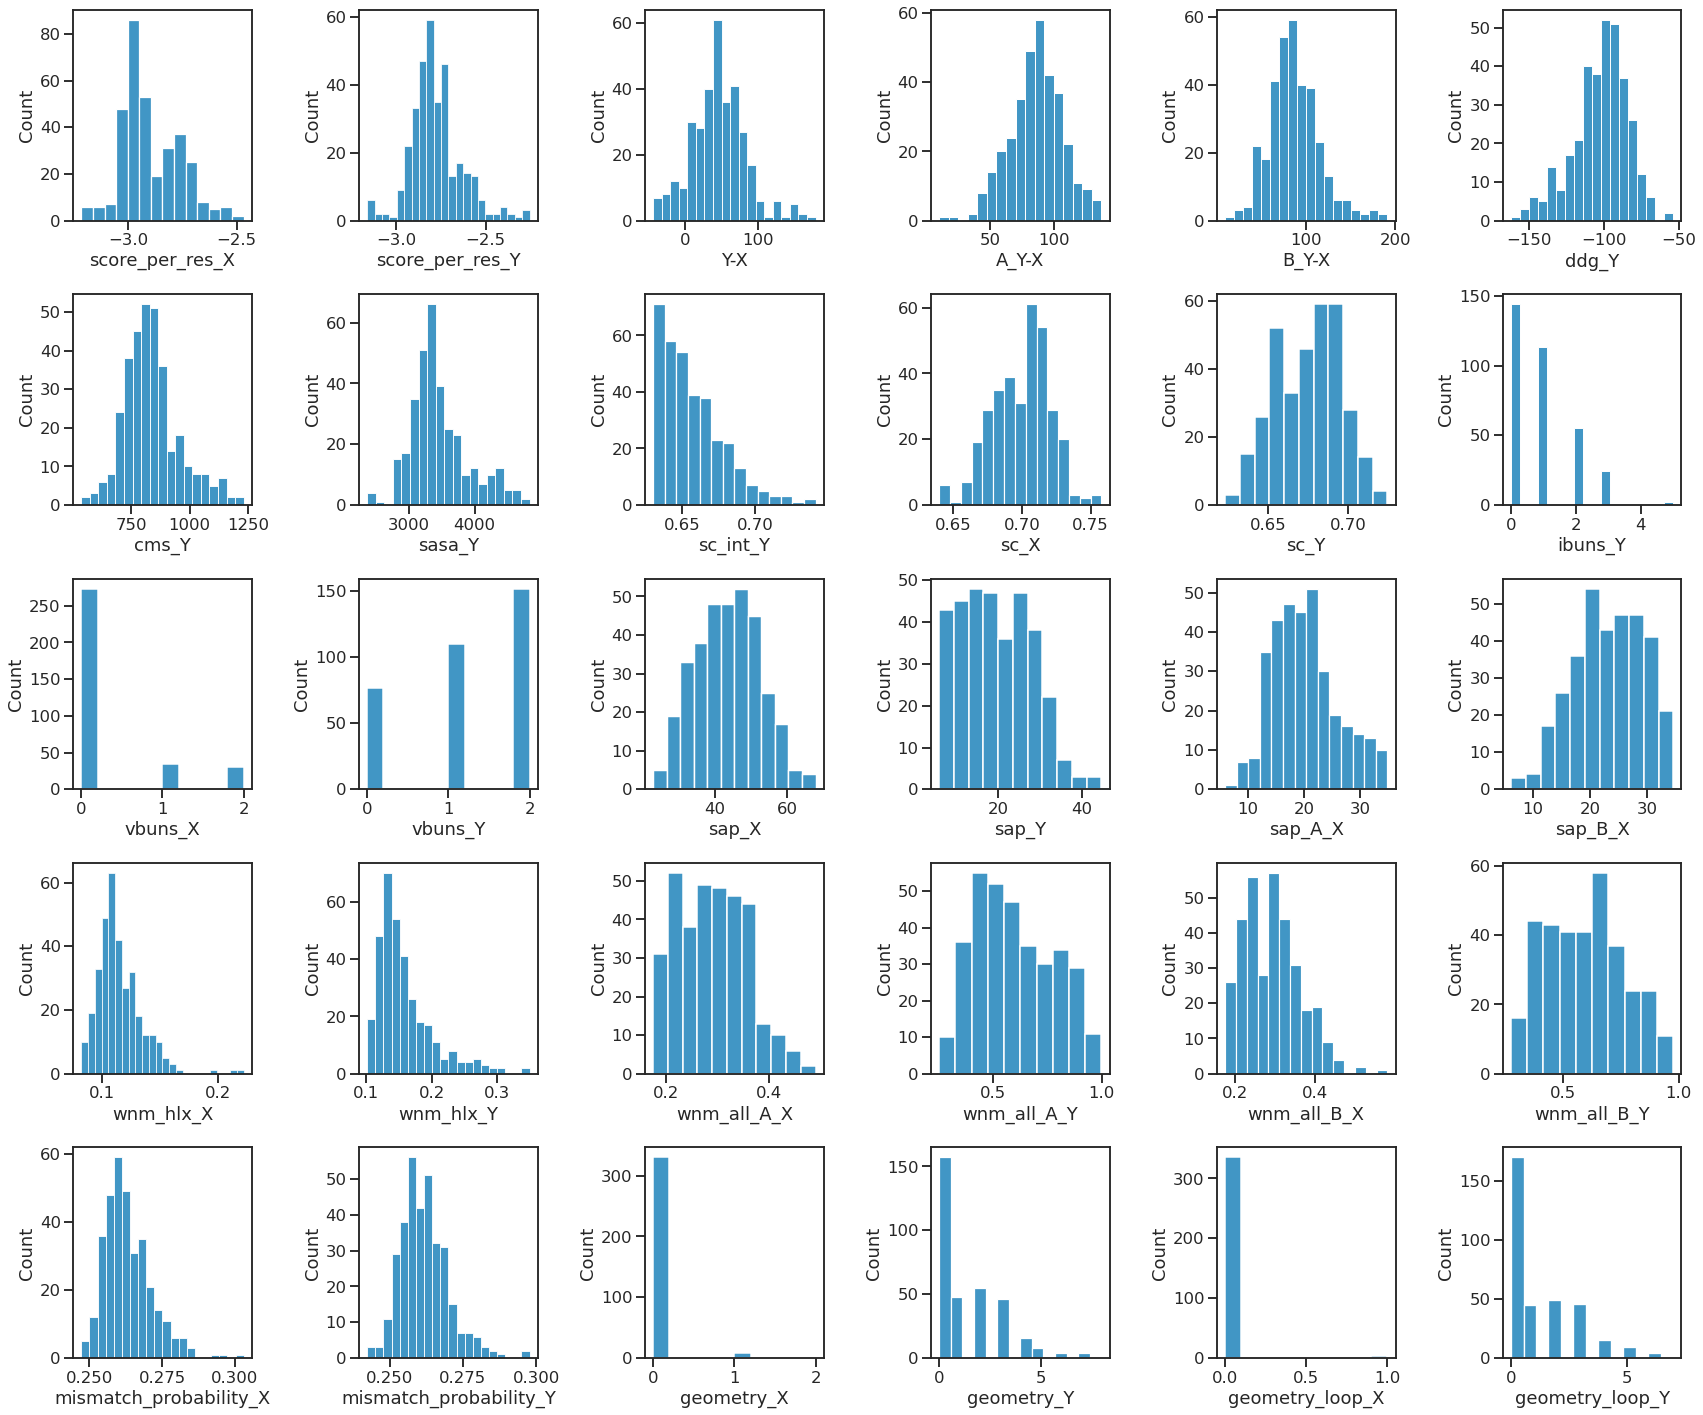

In [39]:
# Filter designs- very lenient, pre-delta filtering

cutoffs = [
        #    ('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.63, 1),
           ('wnm_hlx_X', 0.4, 0),
           ('wnm_hlx_Y', 0.4, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

pre_delta_df = filter_df(scores_df, cutoffs)
print_scores(pre_delta_df)
print(get_parents(pre_delta_df))
histplot_df(pre_delta_df)

In [29]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

parent_path = os.path.join(os.getcwd(), "00_inputs")
parent_scores = os.path.join(parent_path, "scaffold_scores.json")
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
parent_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,
DHR79,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
DHR53,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
DHR54,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


0it [00:00, ?it/s]

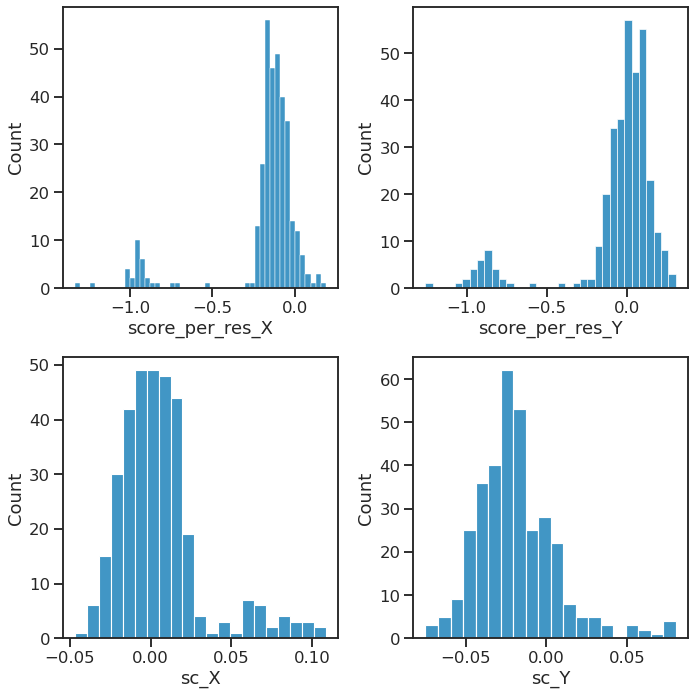

In [40]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('score_per_res_X', 'score_per_res'),
               ('score_per_res_Y', 'score_per_res'),
               ('sc_X', 'ss_sc'),
               ('sc_Y', 'ss_sc')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[pre_delta_df['parent'], :]
parent_aligned_df.index = pre_delta_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = pre_delta_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        # bins=100
    )

plt.tight_layout()

166
23
['X19_3_18_4_ct4_fd', 'X26_3_20_2_ct1_fe', 'X21_4_23_4_ct0_fg', 'X18_4_23_4_ct3_ff', 'X18_4_22_4_ct0_ff', 'hDHR64_5CWM', 'hDHR71_5CWN', 'X24_2_24_2_ct18_fg', 'X23_4_26_3_ct8_fc', 'X20_3_18_2_ct13_fe', 'X23_2_15_3_ct5_fe', 'X28_2_25_2_ct2_fb', 'X26_3_24_2_ct12_fe', 'X19_3_17_2_ct9_fe', 'hDHR79_5CWP', 'X20_3_18_2_ct3_fa', 'X22_3_16_4_ct4_fa', 'hDHR53_5CWK', 'X24_2_24_2_ct5_ff', 'X19_3_17_2_ct28_fe', 'KH_PO11', 'X23_3_20_3_ct7_fc', 'X26_3_23_4_ct1_fd']


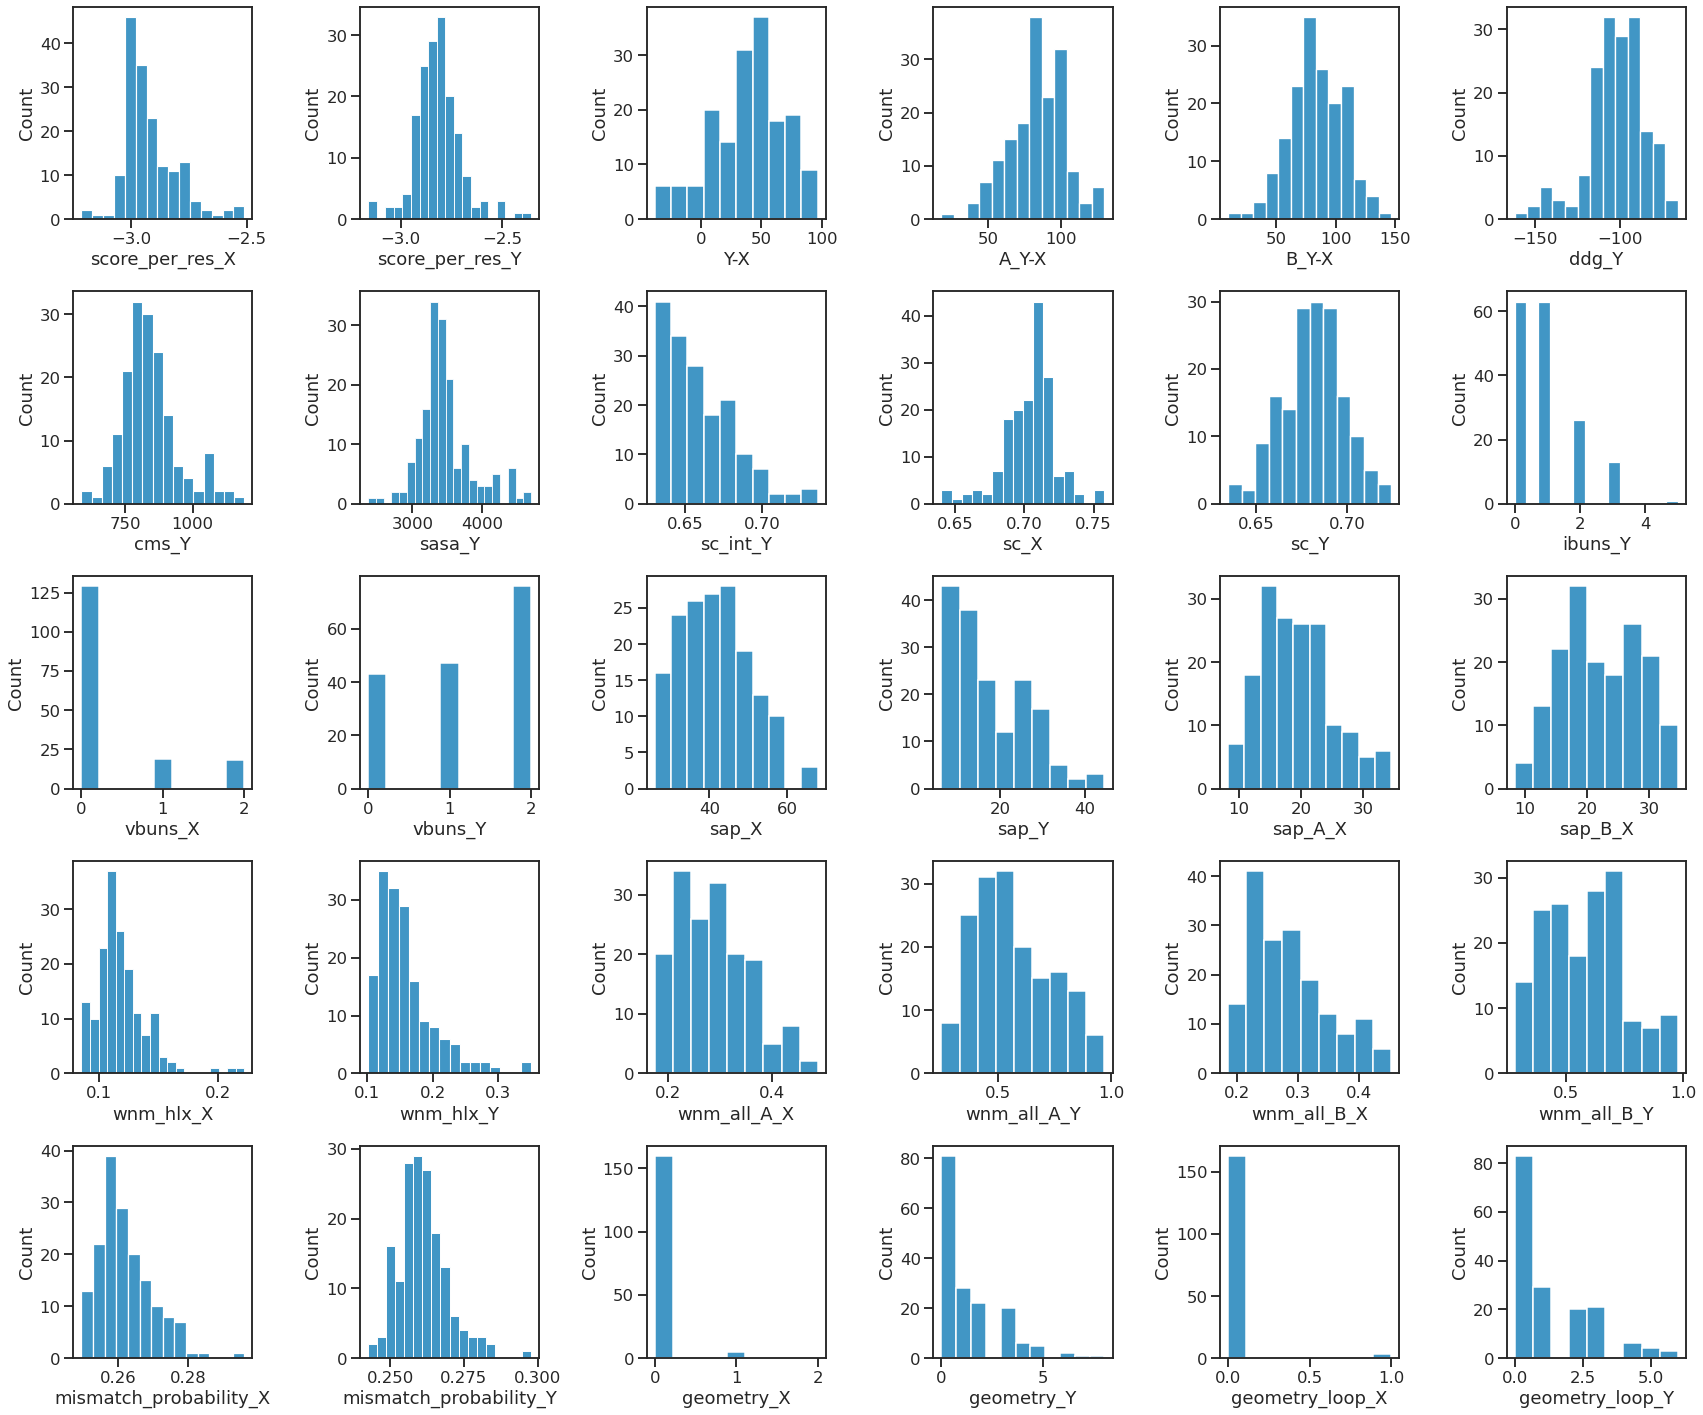

In [58]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('score_per_res_X', 'score_per_res', 0, 0),
                 ('score_per_res_Y', 'score_per_res', 0.1, 0),
                 ('sc_X', 'ss_sc', 0.015, 1),
                 ('sc_Y', 'ss_sc', 0.025, 1)]

delta_filtered_df = filter_df_delta(pre_delta_df, parent_df, delta_cutoffs)
print(get_parents(delta_filtered_df))
histplot_df(delta_filtered_df)

0it [00:00, ?it/s]

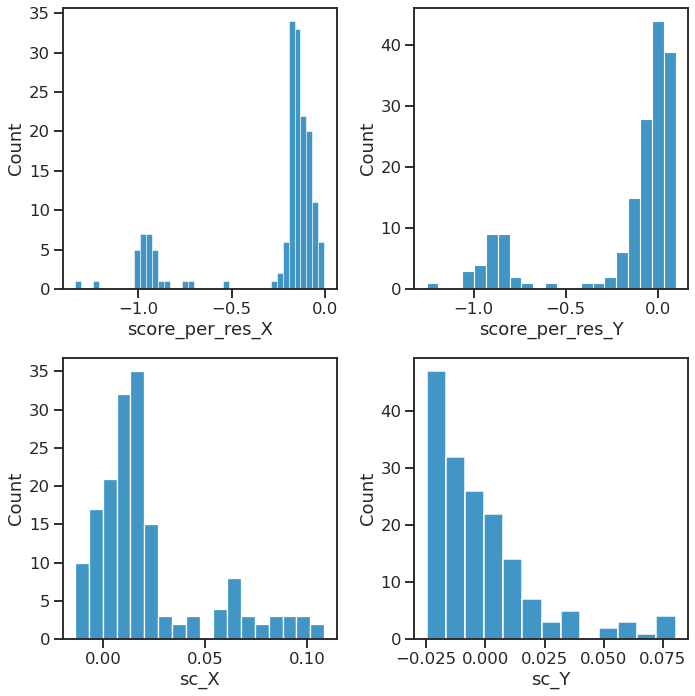

In [59]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('score_per_res_X', 'score_per_res'),
               ('score_per_res_Y', 'score_per_res'),
               ('sc_X', 'ss_sc'),
               ('sc_Y', 'ss_sc')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[delta_filtered_df['parent'], :]
parent_aligned_df.index = delta_filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = delta_filtered_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        # bins=100
    )

plt.tight_layout()